# Problème RP57

In [1]:
import openturns as ot
import numpy as np

## Variables d'entrée

In [2]:
X1 = ot.Normal(0 , 1)
X2 = ot.Normal(0 , 1)

In [3]:
myDistribution=ot.ComposedDistribution([X1, X2])

## Fonction de performance

In [4]:
myFunction = ot.SymbolicFunction(["x1", "x2"], ["min(max(-x1^2 + x2^3 + 3, 2 - x1 - 8 * x2), (x1 + 3)^2 + (x2 + 3)^2 - 4)"])

In [5]:
vect = ot.RandomVector(myDistribution)
output = ot.CompositeRandomVector(myFunction, vect)
event = ot.ThresholdEvent(output, ot.Less(), 0)

In [6]:
mu = myDistribution.getMean()

## Calcul de la probabilité de défaillance par la méthode de FORM 

In [7]:
solver = ot.Cobyla()
algo = ot.FORM(solver, event,mu)
algo.run()
result = algo.getResult()

In [8]:
result.getEventProbability()

0.04160347361858399

## Calcul de la probabilité de défaillance par la méthode de SORM 

In [9]:
solver = ot.Cobyla()
algo = ot.SORM(solver, event,mu)
algo.run()
result = algo.getResult()

In [10]:
result.getEventProbabilityBreitung()


0.0003027258197213018

## Calcul de la probabilité de défaillance par la méthode du Tirage d'importance 

In [11]:
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()
myImportance = ot.Normal(standardSpaceDesignPoint, [1.0] * 2, ot.CorrelationMatrix(2))
experiment = ot.ImportanceSamplingExperiment(myImportance)
algo = ot.ProbabilitySimulationAlgorithm(ot.StandardEvent(event), experiment)
algo.setMaximumCoefficientOfVariation(0.1)
algo.setMaximumOuterSampling(40000)
algo.setConvergenceStrategy(ot.Full())
algo.run()

In [12]:
result = algo.getResult()
result.getProbabilityEstimate()

0.013290184494802711

## Calcul de la probabilité de défaillance par la méthode de Monte Carlo

In [13]:
algoProb = ot.ProbabilitySimulationAlgorithm(event)
algoProb.setMaximumOuterSampling(1000)
algoProb.setMaximumCoefficientOfVariation(0.01)
algoProb.run()

In [14]:
resultAlgo = algoProb.getResult()
pf = resultAlgo.getProbabilityEstimate()
pf

0.025000000000000005

## Les courbes iso-probables

In [15]:
alphaMin = 0.01
alphaMax = 1 - alphaMin
lowerBound = ot.Point([X1.computeQuantile(alphaMin)[0], X2.computeQuantile(alphaMin)[0]])
upperBound = ot.Point([X1.computeQuantile(alphaMax)[0], X2.computeQuantile(alphaMax)[0]])


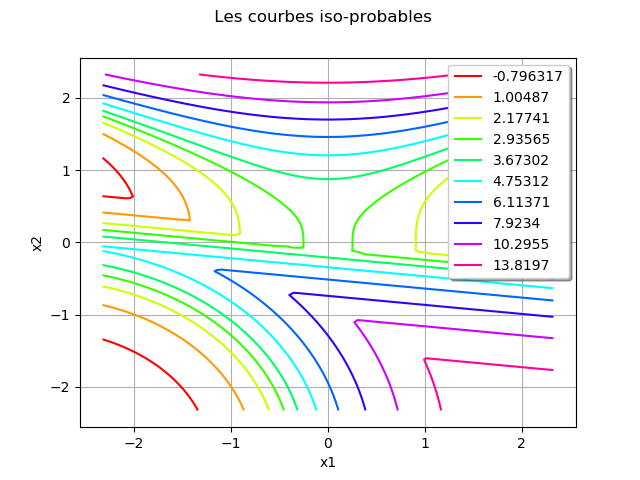

In [16]:
nbPoints = [100, 100]
figure = myFunction.draw(lowerBound, upperBound, nbPoints)
figure.setTitle(" Les courbes iso-probables")
figure

## Afiichage Points défaillants / fiables

In [17]:
sampleSize = 5000
sampleInput = myDistribution.getSample(sampleSize)
Y = myFunction(sampleInput)
Yarray = np.array(Y)
indices = Yarray > 0.0
indices = indices.ravel()
Xarray = np.array(sampleInput)
XPositif = Xarray[indices, :]
autresIndices = [not indices[i] for i in range(len(indices))]
XNegatifs = Xarray[autresIndices, :]


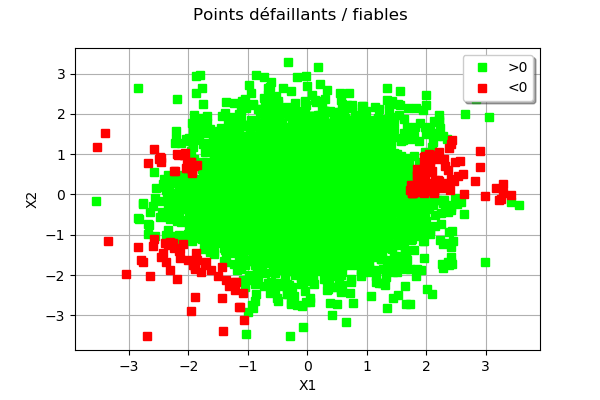

In [18]:
myGraph = ot.Graph('Points défaillants / fiables', 'X1', 'X2', True, '')
myCloud = ot.Cloud(ot.Sample(XPositif), 'green', 'fsquare', '>0')
myGraph.add(myCloud)
myCloud = ot.Cloud(ot.Sample(XNegatifs), 'red', 'fsquare', '<0')
myGraph.add(myCloud)
myGraph.setLegendPosition("topright")
myGraph

In [19]:
bounds = ot.Interval(lowerBound, upperBound)
bounds

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-2.32635,-2.32635] upper bound=class=Point name=Unnamed dimension=2 values=[2.32635,2.32635] finite lower bound=[1,1] finite upper bound=[1,1]

In [20]:
nX = 100
nY = 100
boxExperiment = ot.Box([nX, nY], bounds)
#grille régulier 
inputSample = boxExperiment.generate()
outputSample = myFunction(inputSample)

In [21]:
def linearSample(xmin, xmax, npoints):
    '''Returns a sample created from a regular grid
    from xmin to xmax with npoints points.'''
    step = (xmax-xmin)/(npoints-1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

## Surface d'état limite

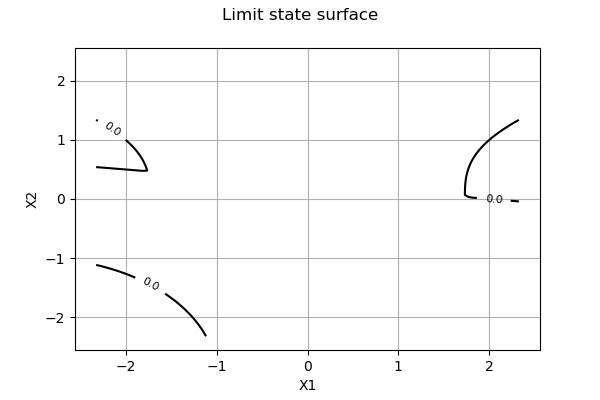

In [22]:
# Create an empty graph
myGraph = ot.Graph('Limit state surface', 'X1', 'X2', True, '')
# Create the contour
levels = ot.Point([0.0])
labels = ["0.0"]
drawLabels = True
x = linearSample(lowerBound[0], upperBound[0], nX + 2)
y = linearSample(lowerBound[1], upperBound[1], nY + 2)
myContour = ot.Contour(x, y, outputSample, levels, labels, drawLabels)
myContour.setColor('black')
myGraph.add(myContour)

myGraph

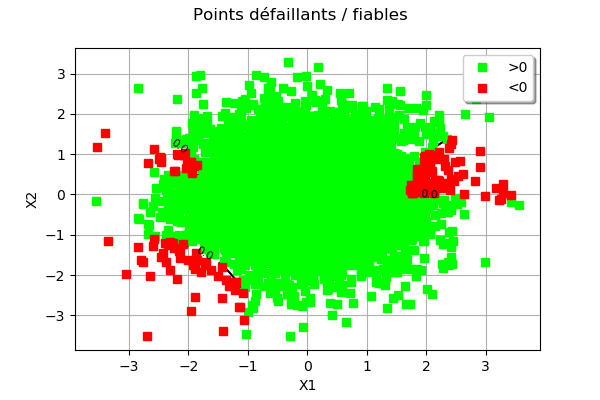

In [23]:
myGraph = ot.Graph('Points défaillants / fiables', 'X1', 'X2', True, '')
myCloud = ot.Cloud(ot.Sample(XPositif), 'green', 'fsquare', '>0')
myGraph.add(myCloud)
myCloud = ot.Cloud(ot.Sample(XNegatifs), 'red', 'fsquare', '<0')
myGraph.add(myCloud)
myGraph.setLegendPosition("topright")
myGraph.add(myContour)
myGraph

## Approximation en polynômes de chaos

In [24]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([X1 , X2])
N = 100 # size of the experimental design

inputTrain = myDistribution.getSample(N)
outputTrain = myFunction(inputTrain)
totalDegree = 7
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
distributionMu = multivariateBasis.getMeasure()
marginalDegrees = [10] * 2
experiment = ot.GaussProductExperiment(distributionMu, marginalDegrees)

In [25]:
projectionStrategy = ot.IntegrationStrategy(experiment)
chaosalgo = ot.FunctionalChaosAlgorithm(myFunction, myDistribution, adaptiveStrategy, projectionStrategy)
chaosalgo.run()
result1 = chaosalgo.getResult()
metamodel = result1.getMetaModel()

In [26]:
n_valid = 500
inputTest = myDistribution.getSample(n_valid)
outputTest = myFunction(inputTest)

In [27]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()
Q2


0.9449409404764564

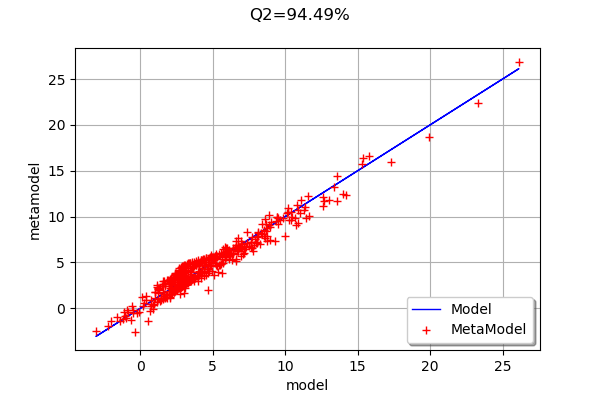

In [28]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2*100))
graph

## Approximation par krigeage

In [29]:
R = ot.CorrelationMatrix(2)
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))
myDistribution = ot.ComposedDistribution([X1, X2], myCopula)

In [30]:
sampleSize_train = 100
X_train = myDistribution.getSample(sampleSize_train)
Y_train = myFunction(X_train)

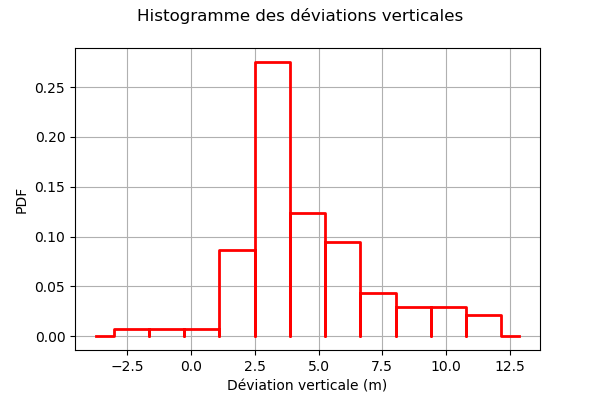

In [31]:
histo = ot.HistogramFactory().build(Y_train).drawPDF()
histo.setXTitle("Déviation verticale (m)")
histo.setTitle("Histogramme des déviations verticales")
histo.setLegends([""])
histo

In [32]:
dimension = myDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

In [33]:
result.getTrendCoefficients()

[class=Point name=Unnamed dimension=1 values=[-613.544]]

In [34]:
result.getCovarianceModel()

class=SquaredExponential scale=class=Point name=Unnamed dimension=2 values=[1.00495,1.02729] amplitude=class=Point name=Unnamed dimension=1 values=[12839]

In [35]:
sampleSize_test = 100
X_test = myDistribution.getSample(sampleSize_test)
Y_test = myFunction(X_test)

In [36]:
Y_test_MM = krigeageMM(X_test)

In [37]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)

In [38]:
val.computePredictivityFactor()

-7769.440460364293

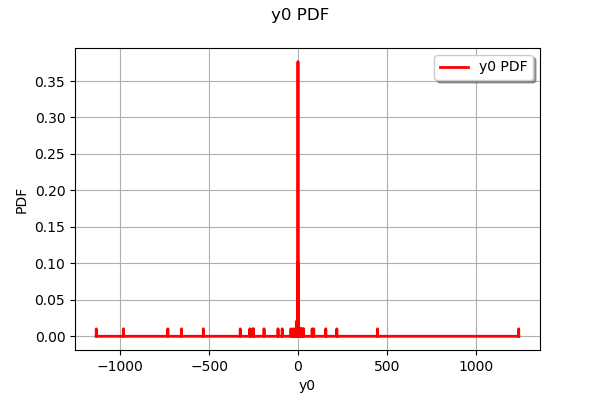

In [39]:
r = val.getResidualSample()
ot.HistogramFactory().build(r).drawPDF()

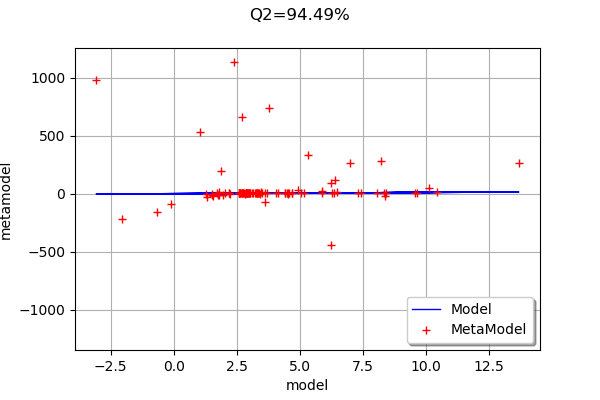

In [40]:
graphe = val.drawValidation()
graphe.setTitle("Q2=%.2f%%" % (Q2*100))
graphe